### Chapter 15 - Heating/Cooling

Newton’s law of cooling asserts that the temperature rate of change for an object is proportional to the difference in temperature between the object and the surrounding environment:

 - dT/dt = -r * (T - T_env)

where T , the temperature of the object, is a function of time, t; T_env is the temperature of the environment, and r is a constant that characterizes how quickly heat is transferred between the system and the environment.

In [17]:
import pandas as pd
from modsim import *

Create an initial state

In [3]:
init = State(T=90)

In [4]:
coffee = System(init=init,
                volume=300,
                r=0.01,
                T_env=22,
                t_0=0,
                t_end=30,
                dt=1)

Function for Newton's law of cooling

In [5]:
def update_func(state, t, system):
    r, T_env, dt = system.r, system.T_env, system.dt
    T = state.T
    T += -r * (T - T_env) * dt
    return State(T=T)

In [6]:
update_func(init, 0, coffee)

,values
T,89.32


Simulation for the cooling process

In [8]:
def run_simulation(system, update_func):
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    return frame

In [9]:
results = run_simulation(coffee, update_func)

In [10]:
def make_system(T_init, r, volume, t_end):
    init = State(T=T_init)
    return System(init=init,r=r,volume=volume,temp=T_init,t_0=0,t_end=t_end,dt=1,T_env=22)

In [11]:
coffee = make_system(T_init=90, r=0.01, volume=300, t_end=30)
results = run_simulation(coffee, update_func)

In [13]:
coffee

,values
init,T 90 dtype: int64
r,0.01
volume,300
temp,90
t_0,0
t_end,30
dt,1
T_env,22


In [14]:
results

,T
0,90
1,89.32
2,88.6468
3,87.980332
4,87.320529
5,86.667323
6,86.02065
7,85.380444
8,84.746639
9,84.119173


Final plot of the simulation where in 30 minutes the temperature dropped ~28C

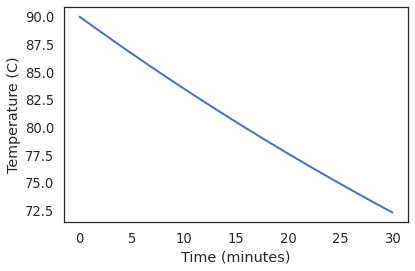

In [16]:
plot(results.T)
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

### Exercises

Exercise: Simulate the temperature of 50 mL of milk with a starting temperature of 5 degC, in a vessel with the same insulation, for 15 minutes, and plot the results.

By trial and error, find a value for r that makes the final temperature close to 20 C.

In [18]:
milk = make_system(T_init=5, t_end=15, r=0.133, volume=50)
results = run_simulation(milk, update_func)
T_final = get_last_value(results.T)

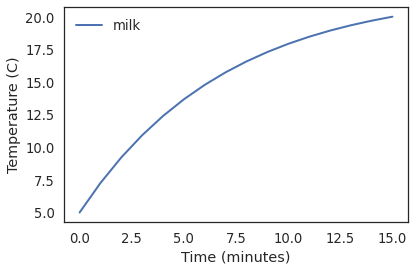

In [19]:
plot(results.T, label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

### Chapter 21 - Air resistance

As an object moves through a fluid, like air, the object applies force to the air and, in accordance with Newton’s third law of motion, the air applies an equal and opposite force to the object. The direction of this drag force is opposite the direction of travel, and its magnitude is given by the drag equation: 

 - F_d = (p * v^2 * C_d * A)/2

where
- F_d is force due to drag, in newtons (N).
- p is the density of the fluid in kg/m 3 .172
- v is the magnitude of velocity in m/s.
- A is the reference area of the object, in m^2
- C_d is the drag coefficient, a dimensionless quantity that depends on the shape of the object (including length but not frontal area), its surface properties, and how it interacts with the fluid.

In [25]:
from modsim import *

In [26]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

Here’s the Params object for the falling penny:

In [35]:
params = System(height = 381,
                v_init = 0,
                g = 9.8,
                mass = 2.5e-3,
                diameter = 19e-3,
                rho = 1.2,
                v_term = 18)

In [38]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    diameter, mass = params.diameter, params.mass
    g, rho = params.g, params.rho, 
    v_init, v_term = params.v_init, params.v_term
    height = params.height
    
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    init = State(y=height, v=v_init)
    t_end = 30
    dt = t_end / 100
    
    return System(params, area=area, C_d=C_d, 
                  init=init, t_end=t_end, dt=dt)

In [39]:
system = make_system(params)

In [40]:
system

,values
height,381.0
v_init,0.0
g,9.8
mass,0.0025
diameter,0.019
rho,1.2
v_term,18.0
area,0.000284
C_d,0.444501
init,y 381.0 v 0.0 dtype: float64


In [44]:
def slope_func(state, t, system):
    y, v = state
    rho, C_d, g = system.rho, system.C_d, system.g
    area, mass = system.area, system.mass
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

In [46]:
def event_func(state, t, system):
    y, v = state
    return y

### Exercise

Run the simulation with an initial velocity, downward, that exceeds the penny's terminal velocity. Hint: You can create a new Params object based on an existing one, like this:

params2 = Params(params, v_init=-30 * m/s)

What do you expect to happen? Plot velocity and position as a function of time, and see if they are consistent with your prediction.

In [41]:
params2 = System(params, v_init=-30)

In [47]:
system2 = make_system(params2)
results, details = run_ode_solver(system2, slope_func, events=event_func, max_step=0.5)
details.message

'A termination event occurred.'

In [48]:
results

,y,v
0.000000,381.000000,-30.000000
0.300000,372.784000,-26.113519
0.600000,365.437107,-23.603435
0.900000,358.673382,-21.927601
1.200000,352.308551,-20.781619
...,...,...
19.500000,20.445930,-18.000000
19.800000,15.045930,-18.000000
20.100000,9.645930,-18.000000
20.400000,4.245930,-18.000000


The falling penny

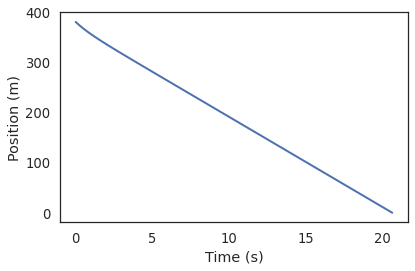

In [55]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)

Velocity increases then is constant

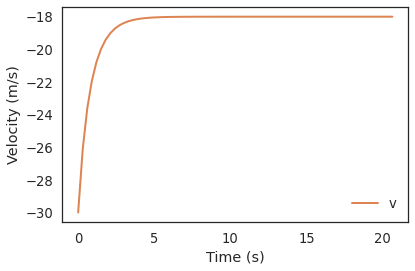

In [53]:
def plot_position(results):
    plot(results.v, color='C1', label='v')
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    

plot_position(results)